# Figure 1: Data overview

Focus on PGx information available in general and compare it to the available information in Africa. For all drugs and then also a focus on our drugs of interest and ADME genes.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import stylia as st
from stylia import NamedColors, ContinuousColorMap, ONE_COLUMN_WIDTH, TWO_COLUMNS_WIDTH

DATAPATH = "../data"
RESULTSPATH = "../results"

colors = NamedColors()
red = colors.get("red")
blue = colors.get("blue")
purple = colors.get("purple")
yellow = colors.get("yellow")
green = colors.get("green")
orange = colors.get("orange")
gray = colors.get("gray")

## Data Cleaning

Data refactoring needed for the figures will be saved under paper/data.

In [2]:
df = pd.read_csv(os.path.join(DATAPATH,"pharmgkb_processed", "13_pgkb_merged.csv"), low_memory=False)
atc = pd.read_csv(os.path.join(DATAPATH, "drugbank", "drugbank_atc_codes.csv"))
len(set(df["cid"])-set(atc["pharmgkb_id"]))
df_ = df.merge(atc, how='left', left_on='cid', right_on='pharmgkb_id')
df_.drop(columns=["pharmgkb_id"], inplace=True)
df2d = df_[["cid", "chemical", "atc_codes", "disease", "is_infectious", "is_noncommunicable"]]
df2d.drop_duplicates(keep="first", inplace=True)
df2d.sort_values(by="cid", inplace=True)
#df2d.to_csv(os.path.join("data", "drugs2disease.csv"), index=False)
print(len(set(df["cid"])), len(set(df_["cid"])), len(set(df2d["cid"])))

1116 1116 1116


/var/folders/rx/fqf_ssrj14q0h5dmx8vgdvpm0000gn/T/ipykernel_92295/4195979470.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2d.drop_duplicates(keep="first", inplace=True)
/var/folders/rx/fqf_ssrj14q0h5dmx8vgdvpm0000gn/T/ipykernel_92295/4195979470.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2d.sort_values(by="cid", inplace=True)


In [3]:
d2d = pd.read_csv("data/drugs2disease_manual.csv")
print(len(set(d2d["cid"])))
d2d = d2d[['cid', 'chemical', 'atc_codes', 'is_infectious','is_noncommunicable']]
d2d = d2d.drop_duplicates(keep="first")
print(d2d.shape)
df_ = df.merge(d2d, how='left', on=['cid', 'chemical'])
print(df.shape, df_.shape)
df_.to_csv(os.path.join("data", "pharmgkb_merged.csv"), index=False)

1116
(1116, 5)
(88784, 12) (88784, 15)


In [4]:
drugs = pd.read_csv(os.path.join(DATAPATH,"of_interest", "curated_drugs_for_gradient.tsv"), sep="\t")
drugs.rename(columns={"Drug":"chemical"}, inplace=True)
drugs["chemical"] = [x.lower() for x in drugs["chemical"]]
#manually change wrong names
chemok = {"rifampicin":"rifampin", "p-aminosalicylic acid":"aminosalicylic acid", "strepomycin":"streptomycin","linezolide":"linezolid"}
drugs["chemical"] = drugs["chemical"].replace(chemok)
chem2cid = pd.read_csv(os.path.join(DATAPATH, "pharmgkb_processed", "0_chemical.csv"))
drugs = drugs.merge(chem2cid[['chemical', 'cid']], on='chemical', how='left')
#manually add missing cids if available in PharmGKB
drugs.loc[drugs['chemical'] == 'delamanid', 'cid'] = "PA166324861"
#Add drug indications
drug_indications = {
    'artemether': 'malaria',
    'lumefantrine': 'malaria',
    'quinine': 'malaria',
    'artesunate': 'malaria',
    'sulfadoxine': 'malaria',
    'pyrimethamine': 'malaria',
    'amodiaquine': 'malaria',
    'dihydroartemisinin': 'malaria',
    'piperaquine': 'malaria',
    'doxycycline': 'malaria',
    'clindamycin': 'malaria',
    'chloroquine': 'malaria',
    'primaquine': 'malaria',
    'mefloquine': 'malaria',
    'streptomycin': 'tuberculosis',
    'rifampin': 'tuberculosis',
    'isoniazid': 'tuberculosis',
    'pyrazinamide': 'tuberculosis',
    'ethambutol': 'tuberculosis',
    'ethionamide': 'tuberculosis',
    'rifapentine': 'tuberculosis',
    'moxifloxacin': 'tuberculosis',
    'levofloxacin': 'tuberculosis',
    'bedaquiline': 'tuberculosis',
    'linezolid': 'tuberculosis',
    'clofazimine': 'tuberculosis',
    'cycloserine': 'tuberculosis',
    'terizidone': 'tuberculosis',
    'delamanid': 'tuberculosis',
    'aminosalicylic acid': 'tuberculosis',
    'pretomanid': 'tuberculosis',
    'capreomycin': 'tuberculosis'
}
drugs['disease'] = drugs['chemical'].map(drug_indications)
drugs.to_csv(os.path.join("data", "curated_drugs.csv"), index=False)

In [33]:
admegenes = pd.read_csv(os.path.join(DATAPATH,"of_interest", "adme_gene_list.tsv"), sep="\t")
admegenes = admegenes.rename(columns={"PharmGKB ID":"gid", "Gene Symbol": "gene"})
print(len(admegenes))
admegenes = admegenes.drop_duplicates(subset=["gene"])
print(len(admegenes))
admegenes.to_csv(os.path.join("data", "adme_genes.csv"), index=False)

284
283


## Communicable vs Non Communicable drugs

Drug annotations for infectious vs non-infectious diseases in PharmGKB.

Diseases in PharmGKB are not grouped in Infectious vs Non Infectious, we have a list of ~3500 conditions. We have used DrugBank and manual annotation to assign a drug class (infections, Non-comm) to each of the 1116 drugs in the curated pgkb.

Q: should we only represent those that go into model training?

In [26]:
df = pd.read_csv(os.path.join("data", "pharmgkb_merged.csv"),low_memory=False)
drugs = pd.read_csv(os.path.join("data", "curated_drugs.csv"))
atc = pd.read_csv(os.path.join(DATAPATH, "drugbank", "drugbank_atc_codes.csv"))

drugs_notann = list(set(drugs["chemical"])-set(df["chemical"]))
print(len(drugs_notann))
drugs_ann = df[df["chemical"].isin(drugs["chemical"])]
print(len(list(set(drugs_ann["chemical"]))))
drugs_counts = drugs_ann["chemical"].value_counts().reset_index()

ncom = df[df["is_noncommunicable"]==1]
com = df[df["is_infectious"]==1]
com_nonsel = com[~com["chemical"].isin(drugs["chemical"])]
ncom_counts = ncom['cid'].value_counts().reset_index()
com_counts = com_nonsel['cid'].value_counts().reset_index()

# ADD Missing Drugs
all_com = atc[atc["is_infectious"]==1]
all_com_nonsel = all_com[~all_com["pharmgkb_id"].isin(drugs["cid"])]["pharmgkb_id"].tolist()
all_ncom = atc[atc["is_noncommunicable"]==1]["pharmgkb_id"].tolist()
non_ann_com = list(set(all_com_nonsel)-set(com_counts["cid"]))
non_ann_ncom = list(set(all_ncom)-set(ncom_counts["cid"]))
com_counts_all = pd.concat([com_counts, pd.DataFrame({"cid":non_ann_com, "count":0})])
ncom_counts_all = pd.concat([ncom_counts, pd.DataFrame({"cid":non_ann_ncom, "count":0})])
drugs_counts_all = pd.concat([drugs_counts,pd.DataFrame({'chemical': list(drugs_notann), 'count': 0})], ignore_index=True)

print(com_counts.shape, com_counts_all.shape)
print(ncom_counts.shape, ncom_counts_all.shape)
print(drugs_counts.shape, drugs_counts_all.shape)

13
19
(143, 2) (285, 2)
(954, 2) (1792, 2)
(19, 2) (32, 2)


In [29]:
def cum_df_nozeroes(df, cid_col):
    bins = [0, 10, 100, 200, 500, 3500]
    labels = ['1-10', '11-100', '101-200', '201-500', '>500']
    df['bin'] = pd.cut(df['count'], bins=bins, labels=labels, right=True)
    reduced_df = df.groupby('bin', observed=False)[cid_col].count().reset_index(name='cid_num')
    total_cids = df[cid_col].count()
    reduced_df['perc_cid'] = (reduced_df['cid_num'] / total_cids) * 100
    return reduced_df

def cum_df_zeroes(df, cid_col):
    bins = [-1,0, 10, 100, 200, 500, 35000]
    labels = ['0','1-10', '11-100', '101-200', '201-500', '>500']
    df['bin'] = pd.cut(df['count'], bins=bins, labels=labels, right=True)
    reduced_df = df.groupby('bin', observed=False)[cid_col].count().reset_index(name='cid_num')
    total_cids = df[cid_col].count()
    reduced_df['perc_cid'] = (reduced_df['cid_num'] / total_cids) * 100
    return reduced_df

com_counts_red = cum_df_nozeroes(com_counts, "cid")
ncom_counts_red = cum_df_nozeroes(ncom_counts, "cid")
drugs_counts_red = cum_df_nozeroes(drugs_counts, "chemical")
com_counts_all_red = cum_df_zeroes(com_counts_all, "cid")
ncom_counts_all_red = cum_df_zeroes(ncom_counts_all, "cid")
drugs_counts_all_red = cum_df_zeroes(drugs_counts_all, "chemical")

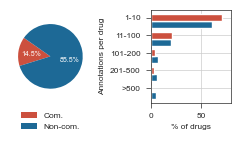

In [30]:
com_drugs = list(set(com["chemical"]))
ncom_drugs = list(set(ncom["chemical"]))

fig, axs = st.create_figure(1,2, width=TWO_COLUMNS_WIDTH*0.37, height=1.475)
ax = axs.next()
sizes = [len(com_drugs), len(ncom_drugs)] #incl TB and Malaria drugs
labels=["Communicable", "Non-communicable"],
ax.pie(sizes, labels=["", ""], colors=[red,blue], autopct='%1.1f%%', startangle=145, wedgeprops=dict(edgecolor='none'), textprops={'color': 'white'})

"""
subset_size = 32-len(drugs_notann)
sizes_overlay = [subset_size, len(com_drugs) - subset_size, len(ncom_drugs)]
overlay_colors = [green, red, blue]
ax.pie(sizes_overlay, colors=overlay_colors, startangle=140, labels=["", "", ""], wedgeprops=dict(edgecolor='none', alpha=0.5))
ax.legend(["Communicable", "Non-communicable", "Malaria/Tb"], loc="lower left")
"""
ax.legend(["Com.", "Non-com."], loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol=1, frameon=False)
st.label(ax, title="", xlabel="", ylabel="", abc="")

def plot_combined_horizontal_bar(ax, df1, df2, labels, colors):
    bar_width = 0.4
    y = np.arange(len(df1))  # Position of bars
    ax.barh(y - bar_width, df1['perc_cid'], height=bar_width, color=colors[0], label=labels[0], edgecolor=None)
    ax.barh(y, df2['perc_cid'], height=bar_width, color=colors[1], label=labels[1], edgecolor=None)
    ax.set_yticks(y)
    ax.set_yticklabels(df1['bin'])
    ax.set_xlim(0, 80)
    plt.tight_layout()

#take all comm incl malaria and TB drugs
com = df[df["is_infectious"]==1]
com_counts = com['cid'].value_counts().reset_index()
com_counts_red = cum_df_nozeroes(com_counts, "cid")
com_counts_red = com_counts_red.sort_values(by=["perc_cid"])
ncom_counts_red = ncom_counts_red.sort_values(by=["perc_cid"])
ax = axs.next()
plot_combined_horizontal_bar(ax, ncom_counts_red, com_counts_red, labels=['Non-communicable', 'Communicable'],  colors=[blue, red])
st.label(ax, xlabel="% of drugs", ylabel="Annotations per drug", title="", abc="")
st.save_figure("assets/drug_class_pie.png")

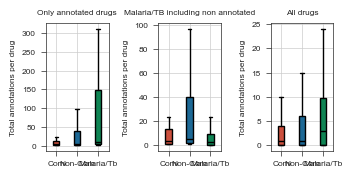

In [31]:
fig, axs = st.create_figure(1,3, width=ONE_COLUMN_WIDTH, height=ONE_COLUMN_WIDTH/2)
ax = axs.next()
colors = [red,blue, green]
medianprops = dict(color="black")
bp = ax.boxplot([com_counts['count'], ncom_counts['count'], drugs_counts["count"]], patch_artist=True, labels=['Com', 'Non-Com', 'Malaria/Tb'], medianprops= medianprops,showfliers=False)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
st.label(ax, title="Only annotated drugs", xlabel="", ylabel="Total annotations per drug", abc="")
ax = axs.next()
colors = [red,blue, green]
medianprops = dict(color="black")
bp = ax.boxplot([com_counts['count'], ncom_counts['count'], drugs_counts_all["count"]], patch_artist=True, labels=['Com', 'Non-Com', 'Malaria/Tb'], medianprops= medianprops,showfliers=False)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
st.label(ax, title="Malaria/TB including non annotated", xlabel="", ylabel="Total annotations per drug", abc="")
ax = axs.next()
colors = [red,blue, green]
medianprops = dict(color="black")
bp = ax.boxplot([com_counts_all['count'], ncom_counts_all['count'], drugs_counts_all["count"]], patch_artist=True, labels=['Com', 'Non-Com', 'Malaria/Tb'], medianprops= medianprops,showfliers=False)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
st.label(ax, title="All drugs", xlabel="", ylabel="Total annotations per drug", abc="")
plt.tight_layout()

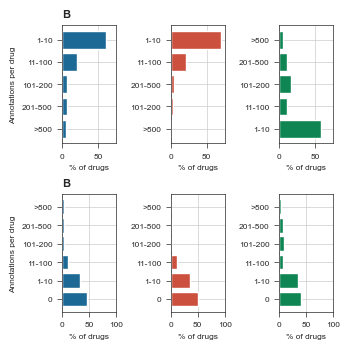

In [32]:
fig, axs = st.create_figure(2,3,width=ONE_COLUMN_WIDTH, height=ONE_COLUMN_WIDTH)
ax = axs.next()
ax.barh(ncom_counts_red['bin'], ncom_counts_red['perc_cid'], color=blue)
ax.set_xlim(0, 75)
st.label(ax, title="", xlabel="% of drugs", ylabel="Annotations per drug", abc="B")
ax = axs.next()
ax.barh(com_counts_red['bin'], com_counts_red['perc_cid'], color=red)
ax.set_xlim(0, 75)
st.label(ax, title="", xlabel="% of drugs", ylabel="", abc="")
ax = axs.next()
ax.barh(drugs_counts_red['bin'], drugs_counts_red['perc_cid'], color=green)
ax.set_xlim(0, 75)
st.label(ax, title="", xlabel="% of drugs", ylabel="", abc="")
ax = axs.next()
ax.barh(ncom_counts_all_red['bin'], ncom_counts_all_red['perc_cid'], color=blue)
ax.set_xlim(0, 100)
st.label(ax, title="", xlabel="% of drugs", ylabel="Annotations per drug", abc="B")
ax = axs.next()
ax.barh(com_counts_all_red['bin'], com_counts_all_red['perc_cid'], color=red)
ax.set_xlim(0, 100)
st.label(ax, title="", xlabel="% of drugs", ylabel="", abc="")
ax = axs.next()
ax.barh(drugs_counts_all_red['bin'], drugs_counts_all_red['perc_cid'], color=green)
ax.set_xlim(0, 100)
st.label(ax, title="", xlabel="% of drugs", ylabel="", abc="")
plt.tight_layout()

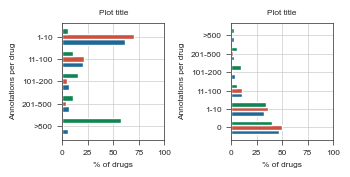

In [33]:
def plot_combined_horizontal_bar(ax, df1, df2, df3, labels, colors):
    bar_width = 0.25
    y = np.arange(len(df1))  # Position of bars

    ax.barh(y - bar_width, df1['perc_cid'], height=bar_width, color=colors[0], label=labels[0])
    ax.barh(y, df2['perc_cid'], height=bar_width, color=colors[1], label=labels[1])
    ax.barh(y + bar_width, df3['perc_cid'], height=bar_width, color=colors[2], label=labels[2])
    
    ax.set_xlabel('% of drugs')
    ax.set_ylabel('Annotations per drug')
    ax.set_yticks(y)
    ax.set_yticklabels(df1['bin'])
    ax.set_xlim(0, 100)
    
    plt.tight_layout()

fig, axs = st.create_figure(1,2, width=ONE_COLUMN_WIDTH, height=ONE_COLUMN_WIDTH/2)
ax = axs.next()
plot_combined_horizontal_bar(ax,
    ncom_counts_red,
    com_counts_red, 
    drugs_counts_red, 
    labels=['Non-communicable', 'Communicable', 'Malaria/Tb'],  # Labels for the legend
    colors=[blue, red, green]  # Colors for the bars
)

ax = axs.next()
plot_combined_horizontal_bar(ax,
    ncom_counts_all_red,
    com_counts_all_red, 
    drugs_counts_all_red, 
    labels=['Non-communicable', 'Communicable', 'Malaria/Tb'],  # Labels for the legend
    colors=[blue, red, green]  # Colors for the bars
)


## Variants vs Annotations

Variants in all genes vs ADME genes, and link to how many annotations available in PharmGKB per each gene

Problem: not all ADME genes are in 1000Genomes annotation - 13 missing.

127


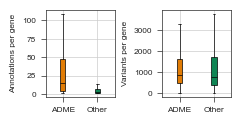

In [72]:
df = pd.read_csv(os.path.join("data", "pharmgkb_merged.csv"), low_memory=False)
admegenes = pd.read_csv(os.path.join("data", "adme_genes.csv"))
genes = admegenes["gene"].tolist()

allvars = pd.read_csv(os.path.join(DATAPATH, "variants", "1000_Genomes", "subset_snvs_protein_coding_1kGPhg38_gene_level.tsv"), sep="\t")
genesmissing = list(set(genes)-set(df["gene"]))
print(len(set(genesmissing)))
admevars = allvars[allvars["gene"].isin(genes)]
nonadmevars = allvars[~allvars["gene"].isin(genes)]
admevars_counts = admevars[['gene', 'total_variants']]
nonadmevars_counts = nonadmevars[['gene', 'total_variants']]

pgx_ann = pd.read_csv(os.path.join(DATAPATH, "pharmgkb_processed", "13_pgkb_merged.csv"), low_memory=False)
admeann = pgx_ann[pgx_ann["gene"].isin(genes)]
nonadmeann = pgx_ann[~pgx_ann["gene"].isin(genes)]
admeann_counts = admeann['gene'].value_counts().reset_index()
nonadmeann_counts = nonadmeann['gene'].value_counts().reset_index()

fig, axs = st.create_figure(1,2, width = TWO_COLUMNS_WIDTH*0.37, height=1.25)
colors = [orange, green]
medianprops = dict(color="black", linewidth=0.5)
boxprops = dict(linewidth=0.5)
whiskerprops = dict(linewidth=0.5)
capprops = dict(linewidth=0.5)

ax = axs.next()
bp = ax.boxplot([admeann_counts['count'], nonadmeann_counts['count']], patch_artist=True, labels=['ADME', 'Other'], medianprops= medianprops,boxprops=boxprops,showfliers=False, whiskerprops=whiskerprops, capprops=capprops)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
st.label(ax, xlabel="", ylabel = "Annotations per gene", title="",abc="")
ax = axs.next()
bp = ax.boxplot([admevars_counts['total_variants'], nonadmevars_counts['total_variants']], patch_artist=True, labels=['ADME', 'Other'], medianprops= medianprops,boxprops=boxprops,showfliers=False, whiskerprops=whiskerprops, capprops=capprops)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
st.label(ax, xlabel="", ylabel = "Variants per gene",  title="", abc="")
plt.tight_layout()
st.save_figure("assets/adme_nonadme_boxplot.png")

In [36]:
width_adme = admevars_counts['total_variants'].sum()/(admevars_counts['total_variants'].sum()+nonadmevars_counts["total_variants"].sum())*1.5
width_nonadme = nonadmevars_counts["total_variants"].sum()/(admevars_counts['total_variants'].sum()+nonadmevars_counts["total_variants"].sum())*1.5
print(width_adme, width_nonadme)

0.018442672768860736 1.481557327231139


## Figure 1C

Origin of variants in ADME Genes. The plots are not very nice, do a table instead - save the CSV and build table manually.
Use Anna's MSc example for the figure

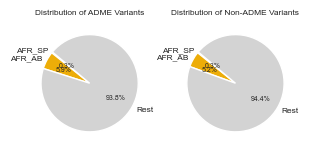

In [38]:
df = pd.read_csv(os.path.join(DATAPATH, "variants", "1000_Genomes", "subset_snvs_protein_coding_1kGPhg38_gene_level.tsv"), sep="\t")

df['rest_variants'] = df["total_variants"] - df['afr_abundant_variants'] - df['afr_specific_variants']
df['perc_missense'] = (df['missense_variants'] / df['total_variants']) * 100
df['perc_intron'] = (df['intron_variants'] / df['total_variants']) * 100
df['perc_other'] = (df['other_variants'] / df['total_variants']) * 100

# what do we do with missing ADME genes?
admegenes = pd.read_csv(os.path.join("data", "adme_genes.csv"))
genes = admegenes["gene"].tolist()

admevars = df[df["gene"].isin(genes)]
nonadmevars = df[~df["gene"].isin(genes)]

afr_ab_adme = admevars["afr_abundant_variants"].sum()
afr_sp_adme = admevars["afr_specific_variants"].sum()
rest_adme = admevars["rest_variants"].sum()

afr_ab = nonadmevars["afr_abundant_variants"].sum()
afr_sp = nonadmevars["afr_specific_variants"].sum()
rest = nonadmevars["rest_variants"].sum()

labels = ['AFR_SP', 'AFR_AB', 'Rest']

colors = [purple, yellow, gray]

fig, axs = st.create_figure(1,2, width=ONE_COLUMN_WIDTH, height=ONE_COLUMN_WIDTH)
ax = axs.next()
sizes = [afr_sp_adme, afr_ab_adme, rest_adme]
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
st.label(ax, title= 'Distribution of ADME Variants', xlabel="", ylabel="", abc="")
ax = axs.next()
sizes = [afr_sp, afr_ab, rest]
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
st.label(ax, title= 'Distribution of Non-ADME Variants', xlabel="", ylabel="", abc="")

In [39]:
#table with percentages
df_sum = pd.DataFrame({
    "Variants":["1kGPhg38", "AFR Abundant", "AFR Specific"],
    "All genes": [df["total_variants"].sum(), f'{df["afr_abundant_variants"].sum()} ({df["afr_abundant_variants"].sum()/df["total_variants"].sum()*100:.2f}%)', f'{df["afr_specific_variants"].sum()} ({df["afr_specific_variants"].sum()/df["total_variants"].sum()*100:.2f}%)'],
    "ADME genes": [admevars["total_variants"].sum(), f'{admevars["afr_abundant_variants"].sum()} ({admevars["afr_abundant_variants"].sum()/admevars["total_variants"].sum()*100:.2f}%)', f'{admevars["afr_specific_variants"].sum()} ({admevars["afr_specific_variants"].sum()/admevars["total_variants"].sum()*100:.2f}%)'],
    "Non ADME genes": [nonadmevars["total_variants"].sum(), f'{nonadmevars["afr_abundant_variants"].sum()} ({nonadmevars["afr_abundant_variants"].sum()/nonadmevars["total_variants"].sum()*100:.2f}%)', f'{nonadmevars["afr_specific_variants"].sum()} ({nonadmevars["afr_specific_variants"].sum()/nonadmevars["total_variants"].sum()*100:.2f}%)'],
})
df_sum

,Variants,All genes,ADME genes,Non ADME genes
0,1kGPhg38,32577572,400545,32177027
1,AFR Abundant,1706781 (5.24%),23490 (5.86%),1683291 (5.23%)
2,AFR Specific,106323 (0.33%),1401 (0.35%),104922 (0.33%)


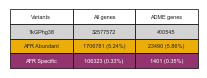

In [4]:
df_sum = df_sum[["Variants", "All genes", "ADME genes"]]
fig, axs = st.create_figure(1,1, width= TWO_COLUMNS_WIDTH*0.28, height=0.78)
ax = axs.next()
ax.axis('off')
table = ax.table(cellText=df_sum.values,
                 colLabels=df_sum.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])
colors = [gray, yellow, purple]
for key, cell in table.get_celld().items():
    if key[0] == len(df_sum):  
        cell.get_text().set_color('white')
for i, color in enumerate(colors):
    for j in range(len(df_sum.columns)): 
        table[(i + 1, j)].set_facecolor(color)
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)
st.label(ax,title="", abc="")
st.save_figure("assets/perc_vars_table.png")

/var/folders/rx/fqf_ssrj14q0h5dmx8vgdvpm0000gn/T/ipykernel_2561/3821245322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admevars["perc_afr_sp"] = (admevars["afr_specific_variants"]/admevars["total_variants"]*100).round(2)
/var/folders/rx/fqf_ssrj14q0h5dmx8vgdvpm0000gn/T/ipykernel_2561/3821245322.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admevars["perc_afr_ab"] = (admevars["afr_abundant_variants"]/admevars["total_variants"]*100).round(2)
/var/folders/rx/fqf_ssrj14q0h5dmx8vgdvpm0000gn/T/ipyke

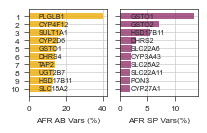

In [5]:
admevars["perc_afr_sp"] = (admevars["afr_specific_variants"]/admevars["total_variants"]*100).round(2)
admevars["perc_afr_ab"] = (admevars["afr_abundant_variants"]/admevars["total_variants"]*100).round(2)

top_afr_sp = admevars.sort_values(by=["perc_afr_sp"]).tail(10)
top_afr_ab = admevars.sort_values(by=["perc_afr_ab"]).tail(10)

fig, axs = st.create_figure(1,2, width=TWO_COLUMNS_WIDTH*0.28, height=1.47)
ax = axs.next()
xlim = ax.get_xlim()
ax.barh(top_afr_ab["gene"], top_afr_ab["perc_afr_ab"], color = yellow, alpha=0.8, linewidth=0)
for i, l in enumerate(top_afr_ab["gene"].tolist()):
    ax.text(xlim[1]*5, i, l, ha="left", va="center")
ax.set_yticklabels([i for i in range(10,0,-1)])
st.label(ax, title="", ylabel="", xlabel="AFR AB Vars (%)", abc="")
ax = axs.next()
xlim = ax.get_xlim()
ax.barh(top_afr_sp["gene"], top_afr_sp["perc_afr_sp"], color = purple,alpha=0.8, linewidth=0)
for i, l in enumerate(top_afr_sp["gene"].tolist()):
    ax.text(xlim[1]*2, i, l, ha="left", va="center")
ax.set_yticklabels("")
st.label(ax, title= "",ylabel="", xlabel="AFR SP Vars(%)", abc="")
plt.tight_layout()
st.save_figure("assets/topgenes_afr.png")

In [18]:
# DO NOT RUN 
import csv
from tqdm import tqdm
top_genes = set(top_afr_sp["gene"].tolist()+top_afr_ab["gene"].tolist())
file_name = "subset_snvs_protein_coding_1kGPhg38.tsv"
R = []
with open(file_name, "r") as f:
    reader = csv.reader(f, delimiter="\t")
    h = next(reader)
    idx = h.index("ANN[*].GENE")
    for r in tqdm(reader):
        g = r[idx]
        if g not in top_genes:
            continue
        R += [r]
top_genes_vars = pd.DataFrame(R, columns=h)
top_genes_vars.to_csv(os.path.join("data", "top_genes_allvars.csv"), index=False)

32577572it [02:30, 216377.92it/s]


,SAMPLE,CHROM,POS,REF,ALT,ANN[*].GENE,ANN[*].GENEID,ANN[*].FEATURE,ANN[*].FEATUREID,ANN[*].BIOTYPE,...,dbNSFP_PROVEAN_pred,dbNSFP_VEST4_score,dbNSFP_clinvar_id,dbNSFP_clinvar_clnsig,dbNSFP_clinvar_trait,dbNSFP_clinvar_review,dbNSFP_clinvar_MedGen_id,dbNSFP_clinvar_OMIM_id,dbNSFP_clinvar_Orphanet_id,dbNSFP_Interpro_domain
0,chr2,2,87009032,A,G,PLGLB1,ENSG00000183281,transcript,ENST00000355705.4,protein_coding,...,.,0.0,.,.,.,.,.,.,.,.
1,chr2,2,87009076,C,T,PLGLB1,ENSG00000183281,transcript,ENST00000355705.4,protein_coding,...,.,0.0,.,.,.,.,.,.,.,.
2,chr2,2,87013458,A,G,PLGLB1,ENSG00000183281,transcript,ENST00000355705.4,protein_coding,...,.,0.0,.,.,.,.,.,.,.,.
3,chr2,2,87013477,G,A,PLGLB1,ENSG00000183281,transcript,ENST00000355705.4,protein_coding,...,.,0.0,.,.,.,.,.,.,.,.
4,chr2,2,87020988,C,T,PLGLB1,ENSG00000183281,transcript,ENST00000355705.4,protein_coding,...,.,0.0,.,.,.,.,.,.,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12506,chr22,22,42123207,A,G,CYP2D6,ENSG00000100197,transcript,ENST00000645361.2,protein_coding,...,.,0.0,.,.,.,.,.,.,.,.
12507,chr22,22,42123211,T,C,CYP2D6,ENSG00000100197,transcript,ENST00000645361.2,protein_coding,...,.,0.0,.,.,.,.,.,.,.,.
12508,chr22,22,42123219,C,T,CYP2D6,ENSG00000100197,transcript,ENST00000645361.2,protein_coding,...,.,0.0,.,.,.,.,.,.,.,.
12509,chr22,22,42123226,C,T,CYP2D6,ENSG00000100197,transcript,ENST00000645361.2,protein_coding,...,.,0.0,.,.,.,.,.,.,.,.


In [51]:
top_genes_vars=pd.read_csv(os.path.join("data", "top_genes_allvars.csv"), low_memory=False)
columns_to_keep = [
    'SAMPLE', 'CHROM', 'POS', 'REF', 'ALT', 
    'ANN[*].GENE', 'ANN[*].GENEID', 'ANN[*].FEATURE', 
    'ANN[*].FEATUREID', 'ANN[*].BIOTYPE', 'ANN[*].EFFECT', 
    'ANN[*].IMPACT', 'ANN[*].HGVS_C', 
    'ANN[*].HGVS_P', 'ID', 'AF', 
    'EAS_AF', 'EUR_AF', 'AFR_AF', 'AMR_AF', 'SAS_AF'
]
top_genes_vars = top_genes_vars[columns_to_keep]

In [57]:
afr_ab = top_genes_vars[top_genes_vars["AFR_AF"]>0.3]
afr_ab.to_csv(os.path.join("data", "afr_ab_selgenes.csv"), index=False)
afr_sp = afr_ab[(afr_ab["EAS_AF"]<0.03)&(afr_ab["EUR_AF"]<0.1)&(afr_ab["AMR_AF"]<0.1)&(afr_ab["SAS_AF"]<0.1)]
afr_sp.to_csv(os.path.join("data", "afr_sp_selgenes.csv"), index=False)

In [67]:
afr_ab_var = afr_ab[afr_ab["ID"]=="rs7255816"]
afr_sp_var = afr_sp[afr_sp["ID"]=="rs680055"]

In [68]:
afr_ab_var[['REF','ALT','EAS_AF','EUR_AF', 'AFR_AF', 'AMR_AF', 'SAS_AF']]
afr_sp_var[['REF','ALT','EAS_AF','EUR_AF', 'AFR_AF', 'AMR_AF', 'SAS_AF']]

,REF,ALT,EAS_AF,EUR_AF,AFR_AF,AMR_AF,SAS_AF
6576,C,G,0.0,0.06,0.38,0.05,0.03


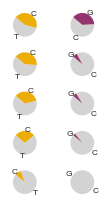

In [70]:
# specific examples 
fig, axs = st.create_figure(5,2, width=TWO_COLUMNS_WIDTH*0.22, height=2.25)
colors_ab = [gray, yellow]
colors_sp = [gray, purple]
pops = ['AFR_AF','EUR_AF', 'AMR_AF', 'SAS_AF','EAS_AF',]
labels_ab = ["T", "C"]
labels_sp = ["C", "G"]
for i,p in enumerate(pops):
    ax = axs[i,0]
    alt = afr_ab_var[p].tolist()
    ax.pie([100-(alt[0]*100), 100*alt[0]], labels = labels_ab, colors=colors_ab, startangle=140,wedgeprops=dict(edgecolor='none'))
    st.label(ax, title="", xlabel="", ylabel="", abc="")
for i,p in enumerate(pops):
    ax = axs[i,1]
    alt = afr_sp_var[p].tolist()
    ax.pie([100-(alt[0]*100), 100*alt[0]], labels = labels_sp, colors=colors_sp, startangle=140,wedgeprops=dict(edgecolor='none'))
    st.label(ax, title="", xlabel="", ylabel="", abc="")
plt.tight_layout()
st.save_figure("assets/vars_pieexample.png")

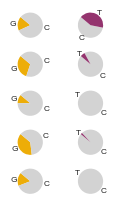

In [19]:
# specific examples from Anna's thesis
rs_ab = pd.read_csv(os.path.join("data", "rs3829740.csv"))
rs_sp = pd.read_csv(os.path.join("data", "rs9465100.csv"))
fig, axs = st.create_figure(5,2, width=TWO_COLUMNS_WIDTH/3.5, height=TWO_COLUMNS_WIDTH/3.5)
colors_ab = [yellow, gray]
colors_sp = [gray, purple]
pops = ["afr", "amr", "eas", "eur", "sas"]
titles = ["AFR", "AMR", "EAS", "EUR", "SAS"]
labels_ab = ["G", "C"]
labels_sp = ["C", "T"]
for i,p in enumerate(pops):
    ax = axs[i,0]
    ax.pie(rs_ab[p].tolist(), labels = labels_ab, colors=colors_ab, startangle=140,wedgeprops=dict(edgecolor='none'))
    if i==0:
        st.label(ax, title="", xlabel="", ylabel="", abc="")
    elif i == 4:
        st.label(ax, title="", xlabel="", ylabel="", abc="")
    else:
        st.label(ax, title="", xlabel="", ylabel="", abc="")
for i,p in enumerate(pops):
    ax = axs[i,1]
    ax.pie(rs_sp[p].tolist(), labels = labels_sp, colors=colors_sp, startangle=140,wedgeprops=dict(edgecolor='none'))
    if i == 4:
        st.label(ax, title="", xlabel="", ylabel="", abc="")
    else:
        st.label(ax, title="", xlabel="", ylabel="", abc="")
plt.tight_layout()

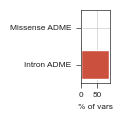

In [57]:
#intron vs missense
vars_all = df["total_variants"].sum()
intron_all = df["intron_variants"].sum()/vars_all*100
missense_all = df["missense_variants"].sum()/vars_all*100
vars_adme = admevars["total_variants"].sum()
intron_adme = admevars["intron_variants"].sum()/vars_adme*100
missense_adme = admevars["missense_variants"].sum()/vars_adme*100
vars_nonadme = nonadmevars["total_variants"].sum()
intron_nonadme = nonadmevars["intron_variants"].sum()/vars_nonadme*100
missense_nonadme = nonadmevars["missense_variants"].sum()/vars_nonadme*100

fig, axs = st.create_figure(1,1, width=ONE_COLUMN_WIDTH/3, height=ONE_COLUMN_WIDTH/3)
ax = axs.next()
ax.barh(['Intron ADME', 'Missense ADME'], [intron_adme, missense_adme], color=[red, blue])
st.label(ax, ylabel="", xlabel="% of vars", title="")
st.save_figure("assets/intron_missense_bar.png")